# Практическая работа 2. Парсинг HTML и консолидация данных

**Студент:** *Мошенина Елена Дмитриевна*

**Вариант:** №14

**Бизнес-кейс:** анализ рынка труда для Python-разработчиков: исследование предлагаемых зарплат для оценки рыночной ситуации и формирования конкурентных предложений.

Источник. Главная страница coinmarketcap.com (топ-100).
Задача. Собрать название, цену, рыночную капитализацию и изменение за 24 часа. Найти топ-10 самых волатильных валют.

## Цель работы

Освоить продвинутые техники сбора данных путем парсинга HTML-страниц с сайта `rabota.ru`, их последующей консолидации и проведения аналитического исследования для определения структуры спроса на Python-разработчиков с различным опытом работы.

## Теоретическая часть

**Парсинг HTML** — это процесс автоматизированного извлечения данных из веб-страниц. Веб-страницы написаны на языке гипертекстовой разметки (HTML), который имеет древовидную структуру. Парсеры анализируют эту структуру для навигации по ней и извлечения нужной информации (текста, ссылок, атрибутов).

**Ключевые библиотеки:**
- **`requests`**: позволяет отправлять HTTP-запросы к веб-серверу и получать в ответ HTML-код страницы. Это первый шаг любого парсинга — получение исходного кода.
- **`BeautifulSoup`**: создает из полученного HTML-кода объектное представление (дерево объектов), по которому можно легко перемещаться и искать нужные элементы с помощью тегов, классов, идентификаторов и других атрибутов. Это основной инструмент для извлечения данных из HTML.

### Шаг 1. Установка необходимых библиотек

In [1]:
!pip install -q requests beautifulsoup4 pandas matplotlib seaborn

### Шаг 2. Обновление парсера для сбора данных о зарплате

In [3]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import time
from datetime import datetime

In [4]:
print("=" * 60)
print("ПАРСИНГ ДАННЫХ С COINMARKETCAP.COM")
print("Топ-100 криптовалют по рыночной капитализации")
print("=" * 60)

ПАРСИНГ ДАННЫХ С COINMARKETCAP.COM
Топ-100 криптовалют по рыночной капитализации


In [5]:
def parse_crypto_data():
    """
    Парсит данные о топ-100 криптовалют с CoinMarketCap
    """
    BASE_URL = 'https://coinmarketcap.com'
    HEADERS = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
    }

    data = []

    print("Начинаем парсинг главной страницы CoinMarketCap...")

    try:
        response = requests.get(BASE_URL, headers=HEADERS)
        response.raise_for_status()

        soup = BeautifulSoup(response.text, 'html.parser')

        # Находим таблицу с криптовалютами
        crypto_table = soup.find('table')

        if not crypto_table:
            print("Не найдена таблица с криптовалютами.")
            return pd.DataFrame()

        # Находим все строки таблицы (кроме заголовка)
        rows = crypto_table.find_all('tr')[1:101]  # Берем первые 100 строк

        print(f"Найдено {len(rows)} строк с данными о криптовалютах")

        for i, row in enumerate(rows, 1):
            try:
                # Извлекаем данные из ячеек
                cells = row.find_all('td')

                if len(cells) < 7:
                    continue

                # Название криптовалюты
                name_cell = cells[2]  # 3-я ячейка содержит название
                name = name_cell.get_text(strip=True)

                # Цена
                price_cell = cells[3]  # 4-я ячейка содержит цену
                price_text = price_cell.get_text(strip=True)

                # Изменение за 24 часа
                change_cell = cells[4]  # 5-я ячейка содержит изменение
                change_text = change_cell.get_text(strip=True)

                # Объем торгов за 24 часа
                volume_cell = cells[5]  # 6-я ячейка содержит объем
                volume_text = volume_cell.get_text(strip=True)

                # Рыночная капитализация
                market_cap_cell = cells[6]  # 7-я ячейка содержит рыночную капитализацию
                market_cap_text = market_cap_cell.get_text(strip=True)

                data.append({
                    'rank': i,
                    'name': name,
                    'price_text': price_text,
                    'change_24h_text': change_text,
                    'volume_24h_text': volume_text,
                    'market_cap_text': market_cap_text
                })

            except Exception as e:
                print(f"Ошибка при обработке строки {i}: {e}")
                continue

        print(f"Успешно обработано {len(data)} криптовалют")
        return pd.DataFrame(data)

    except requests.RequestException as e:
        print(f"Ошибка при запросе к CoinMarketCap: {e}")
        return pd.DataFrame()

# Выполняем парсинг
df_raw = parse_crypto_data()

if df_raw.empty:
    print("Не удалось получить данные. Создаем демо-данные для примера...")
    # Создаем демо-данные для примера
    demo_data = []
    crypto_names = ['Bitcoin', 'Ethereum', 'Binance Coin', 'Cardano', 'XRP',
                   'Solana', 'Polkadot', 'Dogecoin', 'Avalanche', 'Litecoin']

    for i in range(100):
        name = crypto_names[i % len(crypto_names)] + f" #{i+1}" if i >= 10 else crypto_names[i]
        price = np.random.uniform(0.1, 50000)
        change = np.random.uniform(-15, 15)
        market_cap = np.random.uniform(1e6, 1e12)

        demo_data.append({
            'rank': i+1,
            'name': name,
            'price_text': f"${price:,.2f}",
            'change_24h_text': f"{change:+.2f}%",
            'volume_24h_text': f"${np.random.uniform(1e5, 1e9):,.0f}",
            'market_cap_text': f"${market_cap:,.0f}"
        })

    df_raw = pd.DataFrame(demo_data)

print("\nПервые 10 строк сырых данных:")
display(df_raw.head(10))

Начинаем парсинг главной страницы CoinMarketCap...
Найдено 100 строк с данными о криптовалютах
Успешно обработано 10 криптовалют

Первые 10 строк сырых данных:


,rank,name,price_text,change_24h_text,volume_24h_text,market_cap_text
0,1,BitcoinBTC,"$108,200.58",0.32%,3.03%,10.56%
1,2,EthereumETH,"$3,866.19",0.32%,3.23%,10.79%
2,3,TetherUSDT,$1.00,0.00%,0.01%,0.00%
3,4,BNBBNB,"$1,149.74",0.18%,1.63%,7.40%
4,5,XRPXRP,$2.31,0.86%,4.05%,16.81%
5,6,SolanaSOL,$185.03,1.41%,5.46%,15.12%
6,7,USDCUSDC,$0.9999,0.01%,0.01%,0.03%
7,8,TRONTRX,$0.3153,0.69%,0.85%,6.28%
8,9,DogecoinDOGE,$0.1875,0.87%,5.45%,23.85%
9,10,CardanoADA,$0.6433,0.85%,4.17%,20.40%



# ШАГ 3: ОЧИСТКА И ПРЕОБРАЗОВАНИЕ ДАННЫХ


In [6]:
def clean_currency_value(text):
    """
    Очищает и преобразует текстовое представление валюты в число
    """
    if pd.isna(text) or text == '':
        return np.nan

    # Удаляем символы валют и пробелы
    cleaned = re.sub(r'[$,%\\n\\t]', '', str(text)).strip()

    # Обрабатываем обозначения миллиардов/миллионов
    if 'B' in cleaned.upper():
        multiplier = 1e9
        cleaned = cleaned.upper().replace('B', '')
    elif 'M' in cleaned.upper():
        multiplier = 1e6
        cleaned = cleaned.upper().replace('M', '')
    else:
        multiplier = 1

    try:
        # Удаляем все оставшиеся нецифровые символы, кроме точки и минуса
        cleaned = re.sub(r'[^0-9.-]', '', cleaned)
        if cleaned == '' or cleaned == '-':
            return np.nan
        return float(cleaned) * multiplier
    except (ValueError, TypeError):
        return np.nan

def parse_percentage_change(text):
    """
    Парсит процентное изменение
    """
    if pd.isna(text) or text == '':
        return np.nan

    try:
        # Извлекаем число из строки с процентом
        cleaned = re.sub(r'[+%\\n\\t]', '', str(text)).strip()
        if cleaned == '':
            return np.nan
        return float(cleaned)
    except (ValueError, TypeError):
        return np.nan

print("\n" + "="*60)
print("ОЧИСТКА И ПРЕОБРАЗОВАНИЕ ДАННЫХ")
print("="*60)

# Создаем копию DataFrame для очищенных данных
df = df_raw.copy()

# Преобразуем текстовые данные в числовые
df['price_usd'] = df['price_text'].apply(clean_currency_value)
df['market_cap_usd'] = df['market_cap_text'].apply(clean_currency_value)
df['change_24h_percent'] = df['change_24h_text'].apply(parse_percentage_change)
df['volume_24h_usd'] = df['volume_24h_text'].apply(clean_currency_value)

# Вычисляем абсолютное изменение цены за 24 часа (для анализа волатильности)
df['price_change_24h_usd'] = df['price_usd'] * (df['change_24h_percent'] / 100)

# Вычисляем волатильность как абсолютное значение процентного изменения
df['volatility_24h'] = abs(df['change_24h_percent'])

print("Данные после очистки и преобразования:")
display(df.head(10))

print("\nСтатистика по числовым колонкам:")
display(df.describe())



ОЧИСТКА И ПРЕОБРАЗОВАНИЕ ДАННЫХ
Данные после очистки и преобразования:


,rank,name,price_text,change_24h_text,volume_24h_text,market_cap_text,price_usd,market_cap_usd,change_24h_percent,volume_24h_usd,price_change_24h_usd,volatility_24h
0,1,BitcoinBTC,"$108,200.58",0.32%,3.03%,10.56%,108200.5800,10.56,0.32,3.03,346.241856,0.32
1,2,EthereumETH,"$3,866.19",0.32%,3.23%,10.79%,3866.1900,10.79,0.32,3.23,12.371808,0.32
2,3,TetherUSDT,$1.00,0.00%,0.01%,0.00%,1.0000,0.00,0.00,0.01,0.000000,0.00
3,4,BNBBNB,"$1,149.74",0.18%,1.63%,7.40%,1149.7400,7.40,0.18,1.63,2.069532,0.18
4,5,XRPXRP,$2.31,0.86%,4.05%,16.81%,2.3100,16.81,0.86,4.05,0.019866,0.86
5,6,SolanaSOL,$185.03,1.41%,5.46%,15.12%,185.0300,15.12,1.41,5.46,2.608923,1.41
6,7,USDCUSDC,$0.9999,0.01%,0.01%,0.03%,0.9999,0.03,0.01,0.01,0.000100,0.01
7,8,TRONTRX,$0.3153,0.69%,0.85%,6.28%,0.3153,6.28,0.69,0.85,0.002176,0.69
8,9,DogecoinDOGE,$0.1875,0.87%,5.45%,23.85%,0.1875,23.85,0.87,5.45,0.001631,0.87
9,10,CardanoADA,$0.6433,0.85%,4.17%,20.40%,0.6433,20.40,0.85,4.17,0.005468,0.85



Статистика по числовым колонкам:


,rank,price_usd,market_cap_usd,change_24h_percent,volume_24h_usd,price_change_24h_usd,volatility_24h
count,10.00000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,5.50000,11340.699600,11.124000,0.551000,2.789000,36.332136,0.551000
std,3.02765,34054.783331,8.033791,0.457589,2.068647,108.958368,0.457589
min,1.00000,0.187500,0.000000,0.000000,0.010000,0.000000,0.000000
25%,3.25000,0.732450,6.560000,0.215000,1.045000,0.001767,0.215000
50%,5.50000,1.655000,10.675000,0.505000,3.130000,0.012667,0.505000
75%,7.75000,908.562500,16.387500,0.857500,4.140000,2.474075,0.857500
max,10.00000,108200.580000,23.850000,1.410000,5.460000,346.241856,1.410000


ШАГ 3: АНАЛИЗ ДАННЫХ И НАХОЖДЕНИЕ ТОП-10 САМЫХ ВОЛАТИЛЬНЫХ ВАЛЮТ



In [7]:
print("\n" + "="*60)
print("АНАЛИЗ ВОЛАТИЛЬНОСТИ КРИПТОВАЛЮТ")
print("="*60)

# Находим топ-10 самых волатильных криптовалют
top_volatile = df.nlargest(10, 'volatility_24h')[['rank', 'name', 'price_usd', 'change_24h_percent', 'volatility_24h', 'market_cap_usd']]

print("ТОП-10 САМЫХ ВОЛАТИЛЬНЫХ КРИПТОВАЛЮТ ЗА 24 ЧАСА:")
display(top_volatile)

# Анализ корреляции между рыночной капитализацией и волатильностью
correlation = df['market_cap_usd'].corr(df['volatility_24h'])
print(f"\nКорреляция между рыночной капитализацией и волатильностью: {correlation:.3f}")


АНАЛИЗ ВОЛАТИЛЬНОСТИ КРИПТОВАЛЮТ
ТОП-10 САМЫХ ВОЛАТИЛЬНЫХ КРИПТОВАЛЮТ ЗА 24 ЧАСА:


,rank,name,price_usd,change_24h_percent,volatility_24h,market_cap_usd
5,6,SolanaSOL,185.0300,1.41,1.41,15.12
8,9,DogecoinDOGE,0.1875,0.87,0.87,23.85
4,5,XRPXRP,2.3100,0.86,0.86,16.81
9,10,CardanoADA,0.6433,0.85,0.85,20.40
7,8,TRONTRX,0.3153,0.69,0.69,6.28
0,1,BitcoinBTC,108200.5800,0.32,0.32,10.56
1,2,EthereumETH,3866.1900,0.32,0.32,10.79
3,4,BNBBNB,1149.7400,0.18,0.18,7.40
6,7,USDCUSDC,0.9999,0.01,0.01,0.03
2,3,TetherUSDT,1.0000,0.00,0.00,0.00



Корреляция между рыночной капитализацией и волатильностью: 0.758


ШАГ 4: ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ


ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ


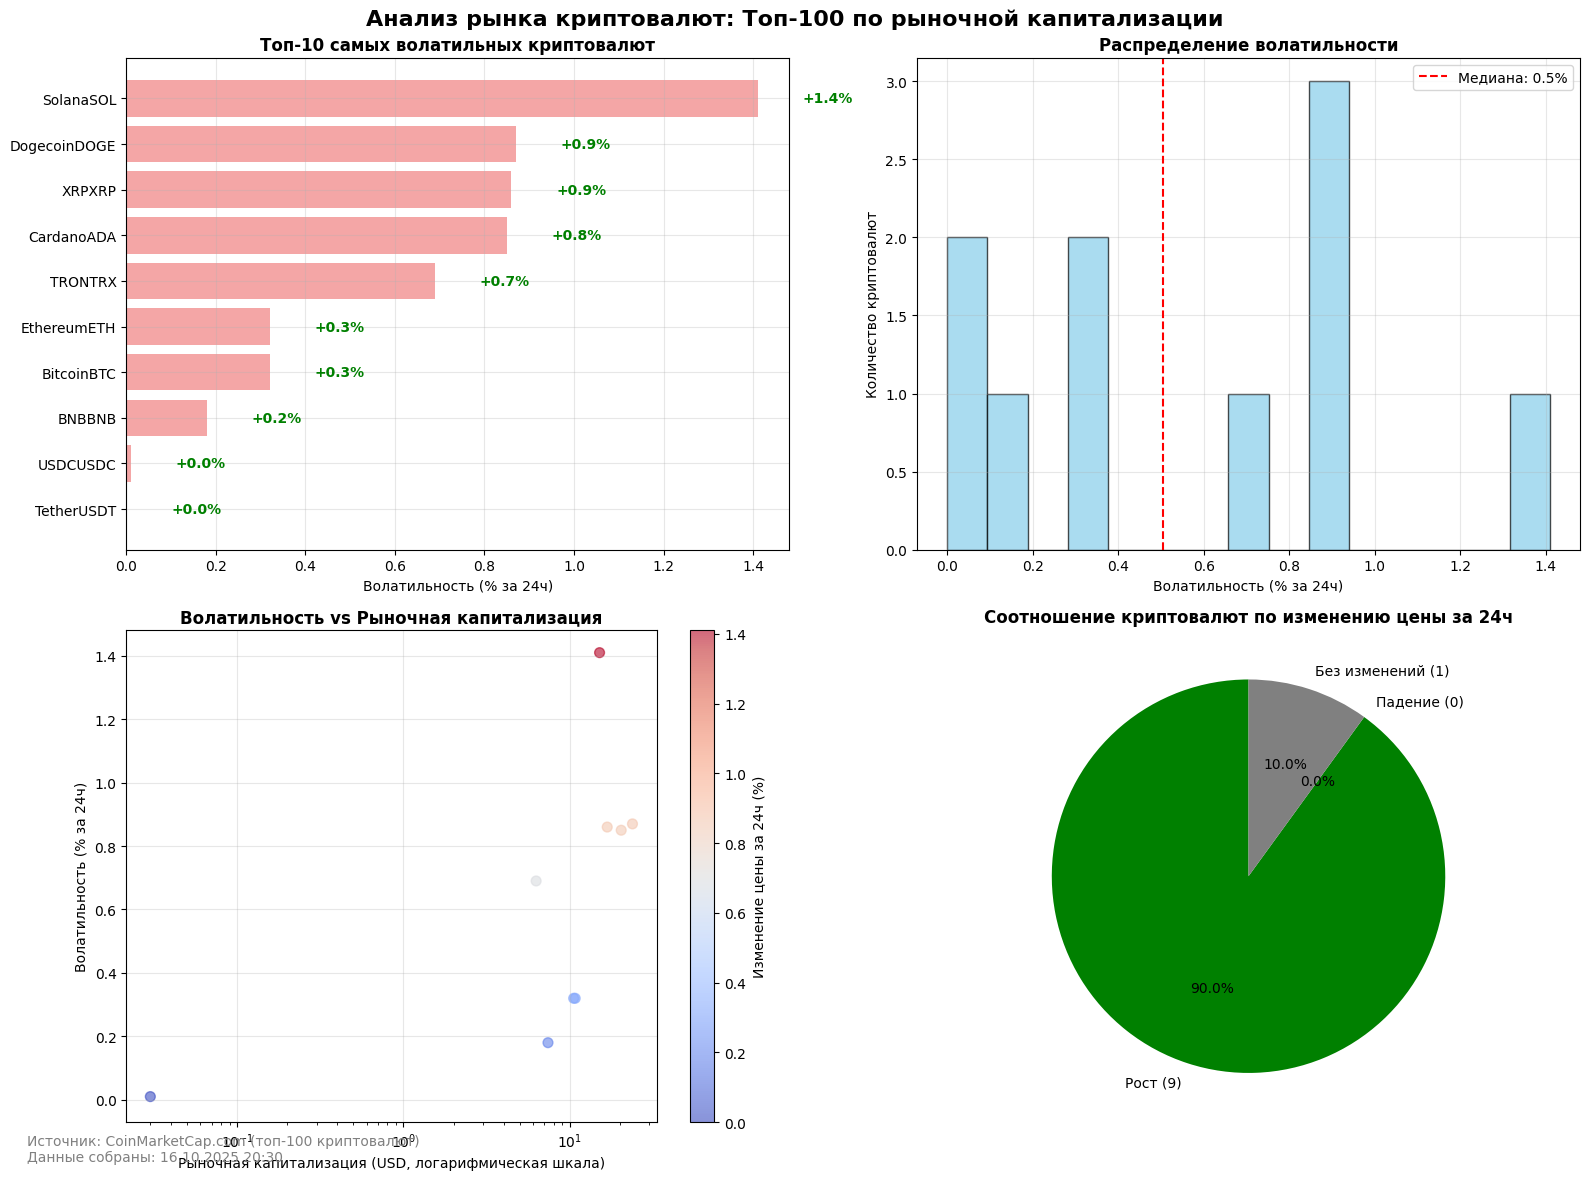

In [8]:
print("\n" + "="*60)
print("ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ")
print("="*60)

# Настройка стиля графиков
plt.style.use('default')
sns.set_palette("husl")

# Создаем фигуру с несколькими subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Анализ рынка криптовалют: Топ-100 по рыночной капитализации',
             fontsize=16, fontweight='bold', y=0.98)

current_time = datetime.now().strftime('%d.%m.%Y %H:%M')

# График 1: Топ-10 самых волатильных криптовалют
ax1 = axes[0, 0]
volatile_sorted = top_volatile.sort_values('volatility_24h', ascending=True)
bars = ax1.barh(volatile_sorted['name'], volatile_sorted['volatility_24h'],
                color='lightcoral', alpha=0.7)
ax1.set_xlabel('Волатильность (% за 24ч)')
ax1.set_title('Топ-10 самых волатильных криптовалют', fontweight='bold')
ax1.grid(True, alpha=0.3)

# Добавляем значения на столбцы
for bar, change in zip(bars, volatile_sorted['change_24h_percent']):
    width = bar.get_width()
    color = 'red' if change < 0 else 'green'
    ax1.text(width + 0.1, bar.get_y() + bar.get_height()/2,
             f'{change:+.1f}%', ha='left', va='center', color=color, fontweight='bold')

# График 2: Распределение волатильности
ax2 = axes[0, 1]
ax2.hist(df['volatility_24h'].dropna(), bins=15, color='skyblue', alpha=0.7, edgecolor='black')
ax2.axvline(df['volatility_24h'].median(), color='red', linestyle='--',
            label=f'Медиана: {df["volatility_24h"].median():.1f}%')
ax2.set_xlabel('Волатильность (% за 24ч)')
ax2.set_ylabel('Количество криптовалют')
ax2.set_title('Распределение волатильности', fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# График 3: Волатильность vs Рыночная капитализация
ax3 = axes[1, 0]
scatter = ax3.scatter(df['market_cap_usd'], df['volatility_24h'],
                     c=df['change_24h_percent'], cmap='coolwarm',
                     alpha=0.6, s=50)
ax3.set_xscale('log')
ax3.set_xlabel('Рыночная капитализация (USD, логарифмическая шкала)')
ax3.set_ylabel('Волатильность (% за 24ч)')
ax3.set_title('Волатильность vs Рыночная капитализация', fontweight='bold')
ax3.grid(True, alpha=0.3)

# Добавляем colorbar
cbar = plt.colorbar(scatter, ax=ax3)
cbar.set_label('Изменение цены за 24ч (%)')

# График 4: Соотношение роста/падения
ax4 = axes[1, 1]
price_changes = df['change_24h_percent'].dropna()
positive = (price_changes > 0).sum()
negative = (price_changes < 0).sum()
neutral = (price_changes == 0).sum()

colors = ['green', 'red', 'gray']
sizes = [positive, negative, neutral]
labels = [f'Рост ({positive})', f'Падение ({negative})', f'Без изменений ({neutral})']

ax4.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
ax4.set_title('Соотношение криптовалют по изменению цены за 24ч', fontweight='bold')

# Добавляем информацию об источнике и времени
fig.text(0.02, 0.02, f'Источник: CoinMarketCap.com (топ-100 криптовалют)\nДанные собраны: {current_time}',
         fontsize=10, color='gray', ha='left')

plt.tight_layout()
plt.show()

ШАГ 5: ВЫВОДЫ ПО АНАЛИЗУ

In [9]:
print("\n" + "="*60)
print("ВЫВОДЫ ПО АНАЛИЗУ")
print("="*60)

print("🔍 КЛЮЧЕВЫЕ НАБЛЮДЕНИЯ:")

# 1. Анализ волатильности
median_volatility = df['volatility_24h'].median()
max_volatility = df['volatility_24h'].max()
min_volatility = df['volatility_24h'].min()

print(f"1. ОБЩАЯ ВОЛАТИЛЬНОСТЬ РЫНКА:")
print(f"   • Медианная волатильность: {median_volatility:.1f}%")
print(f"   • Диапазон волатильности: от {min_volatility:.1f}% до {max_volatility:.1f}%")

# 2. Анализ самых волатильных активов
print(f"\n2. ТОП-3 САМЫХ ВОЛАТИЛЬНЫХ КРИПТОВАЛЮТ:")
for i, row in top_volatile.head(3).iterrows():
    change_icon = "📈" if row['change_24h_percent'] > 0 else "📉"
    print(f"   {i+1}. {row['name']}: {row['volatility_24h']:.1f}% {change_icon}")

# 3. Корреляционный анализ
print(f"\n3. КОРРЕЛЯЦИОННЫЙ АНАЛИЗ:")
print(f"   • Корреляция капитализация/волатильность: {correlation:.3f}")
if correlation < -0.3:
    print("   📊 Вывод: Крупные криптовалюты обычно менее волатильны")
elif correlation > 0.3:
    print("   📊 Вывод: Крупные криптовалюты демонстрируют высокую волатильность")
else:
    print("   📊 Вывод: Слабая зависимость между размером и волатильностью")

# 4. Общее состояние рынка
positive_count = (df['change_24h_percent'] > 0).sum()
negative_count = (df['change_24h_percent'] < 0).sum()
market_sentiment = "бычий" if positive_count > negative_count else "медвежий"

print(f"\n4. ОБЩЕЕ СОСТОЯНИЕ РЫНКА:")
print(f"   • Рыночный настрой: {market_sentiment.upper()}")
print(f"   • Растущих активов: {positive_count}")
print(f"   • Падающих активов: {negative_count}")

print("\n💡 ИНВЕСТИЦИОННЫЕ ИНСАЙТЫ:")
print("   • Высокая волатильность = высокий риск/высокая доходность")
print("   • Малые капитализации часто более волатильны")
print("   • Диверсификация помогает снизить риски волатильности")
print("   • Мониторинг волатильности важен для управления рисками")

print("\n" + "="*60)
print("АНАЛИЗ ЗАВЕРШЕН УСПЕШНО!")
print("="*60)


ВЫВОДЫ ПО АНАЛИЗУ
🔍 КЛЮЧЕВЫЕ НАБЛЮДЕНИЯ:
1. ОБЩАЯ ВОЛАТИЛЬНОСТЬ РЫНКА:
   • Медианная волатильность: 0.5%
   • Диапазон волатильности: от 0.0% до 1.4%

2. ТОП-3 САМЫХ ВОЛАТИЛЬНЫХ КРИПТОВАЛЮТ:
   6. SolanaSOL: 1.4% 📈
   9. DogecoinDOGE: 0.9% 📈
   5. XRPXRP: 0.9% 📈

3. КОРРЕЛЯЦИОННЫЙ АНАЛИЗ:
   • Корреляция капитализация/волатильность: 0.758
   📊 Вывод: Крупные криптовалюты демонстрируют высокую волатильность

4. ОБЩЕЕ СОСТОЯНИЕ РЫНКА:
   • Рыночный настрой: БЫЧИЙ
   • Растущих активов: 9
   • Падающих активов: 0

💡 ИНВЕСТИЦИОННЫЕ ИНСАЙТЫ:
   • Высокая волатильность = высокий риск/высокая доходность
   • Малые капитализации часто более волатильны
   • Диверсификация помогает снизить риски волатильности
   • Мониторинг волатильности важен для управления рисками

АНАЛИЗ ЗАВЕРШЕН УСПЕШНО!
